In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

In [2]:
path = './input/'
comp = 'germeval2018/'
LSTM_PREDICTION_FILE=f'{path}{comp}LSTM_probabilities.csv'
CNN_PREDICTION_FILE=f'{path}{comp}CNN_probabilities.csv'
TEST_DATA_FILE=f'{path}{comp}germeval2018.sample.txt'

In [3]:
lstm_p = pd.read_csv(LSTM_PREDICTION_FILE, sep="\t", header=None)
cnn_p = pd.read_csv(CNN_PREDICTION_FILE, sep="\t", header=None)

In [4]:
p_res = lstm_p.copy()
p_res[1] = (lstm_p[1] + cnn_p[1]) / 2
p_res[2] = (lstm_p[2] + cnn_p[2]) / 2

In [5]:
preds = p_res.drop([0], axis=1).values


In [6]:
pred_pos = preds.argmax(-1)
pred_pos = pred_pos.astype(float)

## Predict probabilities

In [7]:
 # create a submission
submission = pd.DataFrame(columns=['tweet_text', 'probabilities_neutral', 'probabilities_toxic'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['probabilities_neutral'] = preds[:,0] 
submission['probabilities_toxic'] = preds[:,1]
# dummy value
submission.to_csv(f"{path}{comp}Ensemble_probabilities.csv", sep="\t", index=False, header=False)

## Create submission file

In [8]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'binary', 'multiclass'])
# read original tweet text
test = pd.read_csv(LSTM_PREDICTION_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['binary'] = pred_pos 
mapping = {0 :'OTHER', 1: 'OFFENSE'}
submission = submission.replace({'binary': mapping})
# dummy value
submission['multiclass'] = 'OTHER'
submission.to_csv(f"{path}{comp}Ensemble_submit.csv", sep="\t", index=False, header=False)

# Print AUC curve

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle



In [10]:
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
#perform binary classification
test = test[[1,0]]
test.columns = ['sentiment', 'tweet_text']
test.applymap(lambda x: x.strip() if type(x) is str else x)


mapping = {'OTHER': 0, 'OFFENSE': 1}
test = test.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
test['sentiment'] = test['sentiment'].astype(np.float32)

list_sentences_test = test.tweet_text
y_test = test.sentiment.values

In [11]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, preds[:,i])

    roc_auc[i] = auc(fpr[i], tpr[i])




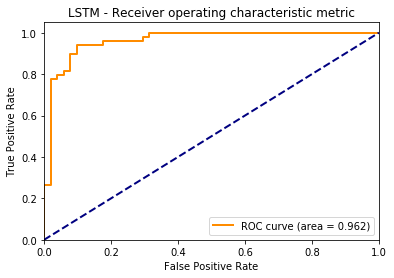

In [12]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM - Receiver operating characteristic metric')
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, pred_pos))

             precision    recall  f1-score   support

        0.0       0.83      0.96      0.89        51
        1.0       0.95      0.80      0.87        49

avg / total       0.89      0.88      0.88       100

